In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [2]:
# La imagen sin proyectar se llama ppc (pseudo plate carree)
ppc = mpimg.imread('equirectangular.jpeg')
print(type(ppc))

<class 'numpy.ndarray'>


In [3]:
print(ppc.dtype)
ppc_shape = ppc.shape
ppc_shape # (rows, cols, bands)

uint8


(1036, 2058, 3)

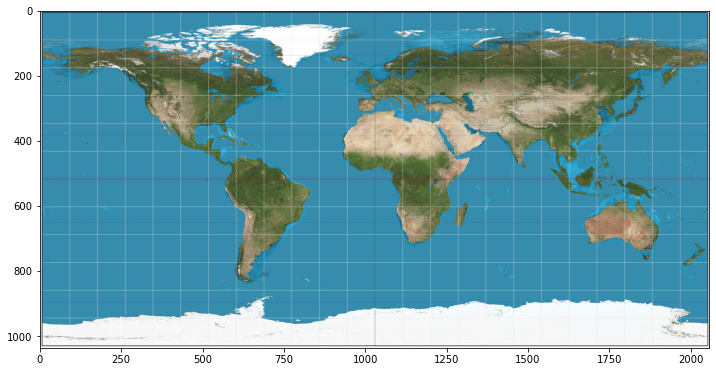

In [4]:
ax = plt.figure(figsize=(12,12))
imgplot = plt.imshow(ppc)

In [5]:
# Defino el boundig box en coordenadas del mapa (up, left, low, right)
ppc_ullr = (90, -180, -90, 180)

In [6]:
# Obtener el pixel size (height, width) en unidades del mapa
def get_ps(ullr, shape):
    ps_height = -(ullr[2]-ullr[0])/shape[0]
    ps_width = (ullr[3]-ullr[1])/shape[1]
    return (ps_height, ps_width)

In [7]:
ppc_ps = get_ps(ppc_ullr, ppc_shape)
ppc_ps

(0.17374517374517376, 0.1749271137026239)

In [8]:
# Plotear un array en coordenadas del mapa (yx)
def plotear(array, ullr, size):
    array_extent = (ullr[1], ullr[3], ullr[2], ullr[0]) #(left, right, bottom, top)
    ax = plt.figure(figsize=(size, size))
    array_plt = plt.imshow(array, extent=array_extent)
    return array_plt

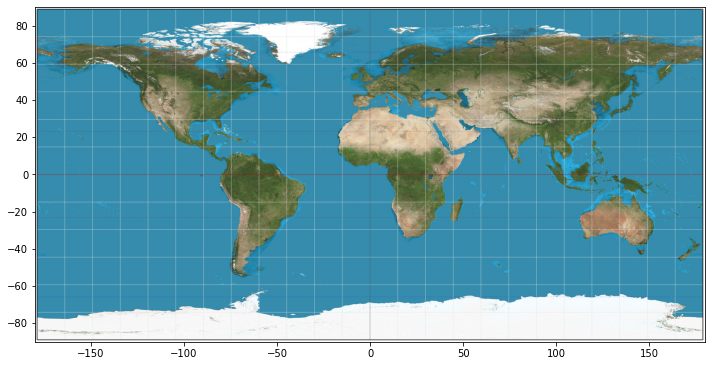

In [9]:
ppc_plot = plotear(ppc, ppc_ullr, 12)

In [10]:
# Obtener las coordenadas del mapa (yx) dadas las coordenadas del pixel (rowcol)
def rowcol2yx(rowcol, ullr, ps):
    y = ullr[0] - (ps[0] * (rowcol[0] + 0.5))
    x = ullr[1] + (ps[1] * (rowcol[1] + 0.5))
    return (y, x)

In [11]:
rowcol2yx((776, 1800), ppc_ullr, ppc_ps)

(-44.91312741312743, 134.9562682215743)

In [12]:
# Obtener las coordenadas del pixel (rowcol) más cercano dadas las coordenadas del mapa (yx)
def yx2rowcol(yx, ullr, shape):
    height = ullr[0] - ullr[2] # Altura de la imagen en unidades del mapa (up - low)
    rows_y = shape[0] / height # Cuántas filas mide una unidad de altura
    y_distance = ullr[0] - yx[0] # Unidades desde el up hasta la y
    row = (rows_y * y_distance) - 0.5
    # TODO: Agregar condiciones para row < -0.5 y para row > shape[0] - 0,5
    if row < 0:
        row = 0
    elif row > shape[0] - 1:
        row = shape[0] - 1
    else:
        row = round(row)
    
    width = ullr[3] - ullr[1] # Anchura de la imagen en unidades del mapa (rigth - left)
    cols_x = shape[1] / width # Cuántas columnas mide una unidad de anchura
    x_distance = yx[1] - ullr[1] # Unidades desde la x hasta el left
    col = (cols_x * x_distance) - 0.5
    # TODO: Agregar condiciones para col < -0.5 y para col > shape[0] - 0,5
    if col < 0:
        col = 0
    elif col > shape[1] - 1:
        col = shape[1] - 1
    else:
        col = round(col)
    
    return (row, col)

In [13]:
yx2rowcol((-45, 135), ppc_ullr, ppc.shape)

(776, 1800)

In [14]:
# Proyeccion pseudo plate carree dadas las coordenadas geo (latlon en radianes)
def latlon2ppc(latlon):
    ppc_y = np.degrees(latlon[0])
    ppc_x = np.degrees(latlon[1])
    return (ppc_y, ppc_x)

In [15]:
latlon2ppc((np.radians(-45), np.radians(135)))

(-45.0, 135.0)

In [16]:
# Creo una nueva imagen cuadrada de base para las reproyecciones siguientes,
# el rango va de -1 a 1 tanto en x como en y
base = np.zeros((1001, 1001, 3), dtype=np.uint8) #(rows, cols, bands)
base_ullr = (1, -1, -1, 1)
base_ps = get_ps(base_ullr, base.shape)
base_ps

(0.001998001998001998, 0.001998001998001998)

In [17]:
# Defino una nueva proyeccion para la imagen base
# las ecuaciones de transformación son: x = lon/π; y = lat/(π/2)
# la transformación inversa es: lon = x*π; lat = y*(π/2)
# Obtener las coordenadas geo (latlon en radianes) dadas las coordenadas base_yx
def base2latlon(base_yx):
    lat = base_yx[0] * (np.pi / 2)
    lon = base_yx[1] * np.pi
    return (lat, lon)

In [18]:
base2latlon((-0.5, 0.75))

(-0.7853981633974483, 2.356194490192345)

In [19]:
latlon2ppc(base2latlon((-0.5, 0.75)))

(-45.0, 135.0)

In [20]:
# Reproyectar pseudo plate carree a base
# Para cada rowcol en base, transforma a yx, transforma a latlon,
# transforma de latlon a yx de ppc, obtiene rowcol en pcc y copia el valor del pixel
def reproy_base(ppc, ppc_ullr, ppc_ps, base, base_ullr, base_ps):
    for row in range(base.shape[0]):
        for col in range(base.shape[1]):
            base_yx = rowcol2yx((row, col), base_ullr, base_ps)
            latlon = base2latlon(base_yx)
            ppc_yx = latlon2ppc(latlon)
            ppc_rowcol = yx2rowcol(ppc_yx, ppc_ullr, ppc.shape)
            base[row,col,:] = ppc[ppc_rowcol[0],ppc_rowcol[1],:]
    return base

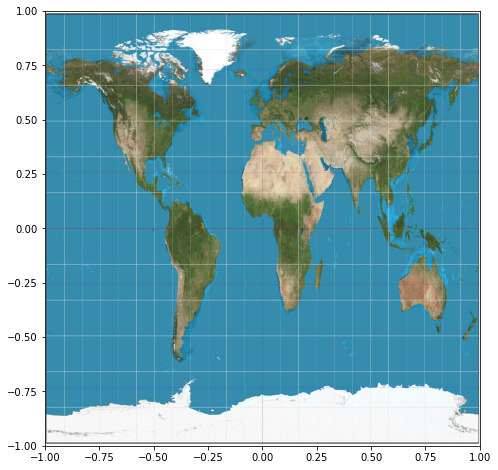

In [21]:
reproyectada = reproy_base(ppc, ppc_ullr, ppc_ps, base, base_ullr, base_ps)
reproy_plot = plotear(reproyectada, base_ullr, 8)

In [22]:
# Defino una nueva proyeccion para la base
# las ecuaciones de transformación son: x = lon/π; y = sin(lat)
# la transformación inversa es: lon = x*π; lat = arcsin(y)
# Obtener las coordenadas geo (latlon en radianes) dadas las coordenadas base_yx
def base2latlon(base_yx):
    lat = np.arcsin(base_yx[0])
    lon = base_yx[1] * np.pi
    return (lat, lon)

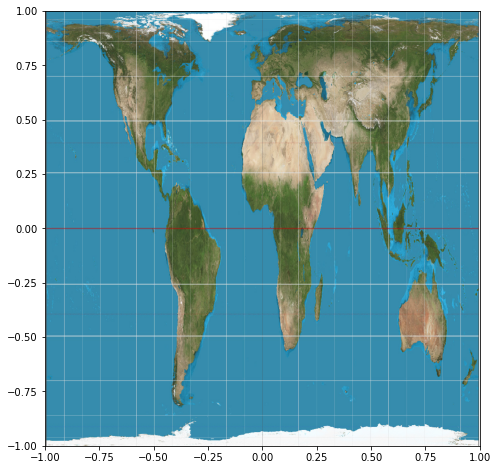

In [23]:
reproyectada = reproy_base(ppc, ppc_ullr, ppc_ps, base, base_ullr, base_ps)
reproy_plot = plotear(reproyectada, base_ullr, 8)

In [24]:
# Defino una nueva proyeccion para la base
# las ecuaciones de transformación son: x = lon/π; y = (lat/(π/2))^(1.25)
# la transformación inversa es: lon = x*π; lat = (y*(π/2))^(1/1.25)
# Obtener las coordenadas geo (latlon en radianes) dadas las coordenadas base_yx
def base2latlon(base_yx):
    if base_yx[0] >= 0:
        lat = np.power(base_yx[0],(1/1.25)) * (np.pi / 2)
    else:
        lat = - np.power(-base_yx[0],(1/1.25)) * (np.pi / 2)
    lon = base_yx[1] * np.pi
    return (lat, lon)

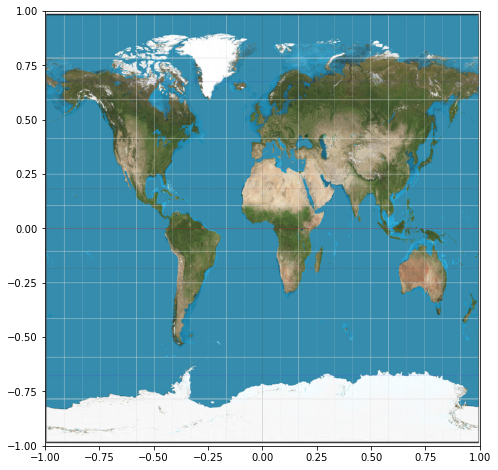

In [25]:
reproyectada = reproy_base(ppc, ppc_ullr, ppc_ps, base, base_ullr, base_ps)
reproy_plot = plotear(reproyectada, base_ullr, 8)